In [ ]:
!git clone https://github.com/mthh/cartogram_geopandas.git
!cd cartogram_geopandas
!python setup.py install

In [3]:
import pandas as pd
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rc('figure', max_open_warning = 0)
plt.rcParams['figure.figsize'] = [10, 5]
import geopandas as gpd
from cartogram_geopandas import make_cartogram
import os
import glob
import imageio

References:

https://github.com/mthh/cartogram_geopandas

https://towardsdatascience.com/visualizing-geospatial-data-in-python-e070374fe621

https://chih-ling-hsu.github.io/2018/05/14/NYC

In [4]:
# download taxi zones
zipfile = "https://s3.amazonaws.com/nyc-tlc/misc/taxi_zones.zip"
taxi_zones = gpd.read_file(zipfile)
taxi_zones = taxi_zones[['zone','LocationID','borough','geometry']]
taxi_zones.rename(columns={'zone':'zone_name','LocationID':'zone'},inplace=True)

In [5]:
taxi_zones.head()

,zone_name,zone,borough,geometry
0,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.770 256767.698, 1026495.593 ..."
3,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,Arden Heights,5,Staten Island,"POLYGON ((935843.310 144283.336, 936046.565 14..."


In [ ]:
# plot shapes
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8), dpi=150)
# boroughs
ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs in NYC")
taxi_zones.plot(column='borough',cmap='Pastel1',ax=ax).axis("off")
# taxi zones
ax = plt.subplot(1, 2, 2)
ax.set_title("Zones in NYC")
taxi_zones.plot(column='zone',cmap='Pastel1',ax=ax).axis("off")

In [ ]:
# download trips data
service = 'yellow' # 'yellow', 'green', 'fhv'

for month in [3,8]: # In 2019, March was peak, August was trough
    urllib.request.urlretrieve("https://s3.amazonaws.com/nyc-tlc/trip+data/"+ \
                               f"{service}_tripdata_2019-{month}.csv", 
                               os.path.join("trip_data",service,f"trips_2019-{month}.csv"))

In [9]:
# import green trips data
green_df = pd.read_csv(os.path.join("trip_data","green","trips_2019-3.csv"),
                       parse_dates=['lpep_pickup_datetime','lpep_dropoff_datetime'],
                       usecols=[1,2,5,6,7])
green_df.rename(columns={'lpep_pickup_datetime':'pu_dt','lpep_dropoff_datetime':'do_dt',
                        'PULocationID':'pu_zone','DOLocationID':'do_zone','passenger_count':'pax'},
                inplace=True)
green_df.head()

,pu_dt,do_dt,pu_zone,do_zone,pax
0,2019-03-01 00:02:21,2019-03-01 00:04:52,193,193,1
1,2019-03-01 00:42:31,2019-03-01 00:47:42,80,256,1
2,2019-03-01 00:15:53,2019-03-01 00:18:37,7,179,1
3,2019-02-28 23:55:58,2019-03-01 00:01:30,256,80,1
4,2019-03-01 00:55:58,2019-03-01 00:58:12,223,223,1


In [10]:
# import yellow trips data
yellow_df = pd.read_csv(os.path.join("trip_data","yellow","trips_2019-3.csv"),
                       parse_dates=['tpep_pickup_datetime','tpep_dropoff_datetime'],
                       usecols=[1,2,3,7,8])
yellow_df.rename(columns={'tpep_pickup_datetime':'pu_dt','tpep_dropoff_datetime':'do_dt',
                        'PULocationID':'pu_zone','DOLocationID':'do_zone','passenger_count':'pax'},
                inplace=True)
yellow_df.head()

,pu_dt,do_dt,pax,pu_zone,do_zone
0,2019-03-01 00:24:41,2019-03-01 00:25:31,1,145,145
1,2019-03-01 00:25:27,2019-03-01 00:36:37,2,95,130
2,2019-03-01 00:05:21,2019-03-01 00:38:23,1,249,28
3,2019-03-01 00:48:55,2019-03-01 01:06:03,1,138,98
4,2019-03-01 00:11:42,2019-03-01 00:16:40,1,48,48


In [ ]:
trips_df = pd.concat((green_df,yellow_df),axis=0)
del green_df
del yellow_df

In [ ]:
# import data -> df

# all_files = glob.iglob(os.path.join("trip_data","green", "*.csv")) 
# trips_df <- pd.concat((pd.read_csv(f,
#                                    parse_dates=['lpep_pickup_datetime','lpep_dropoff_datetime'],
#                                    usecols=[1,2,3,7,8],
#                                    low_memory=False) for f in all_files), 
#                       ignore_index=True)

In [19]:
##### pick-up and drop-off times
trips_df['pu_hr'] = [x.hour + np.floor(4*x.minute/60)/4 for x in trips_df['pu_dt']]
trips_df['do_hr'] = [x.hour + np.floor(4*x.minute/60)/4 for x in trips_df['do_dt']]

# pick-up and drop-off day types
trips_df['pu_day'] = ['weekday' if x.weekday() < 5 else 'weekend' for x in trips_df['pu_dt']]
trips_df['do_day'] = ['weekday' if x.weekday() < 5 else 'weekend' for x in trips_df['do_dt']]

# aggregate trips by taxi zone, day and time
pu_sum = trips_df.groupby(['pu_zone','pu_day','pu_hr'])[['pax']].agg('sum').reset_index()
do_sum = trips_df.groupby(['do_zone','do_day','do_hr'])[['pax']].agg('sum').reset_index()
pu_sum.columns = ['zone','day','hr','pax']
do_sum.columns = ['zone','day','hr','pax']

In [20]:
# cumulative sums
pu_sum.sort_values(by=['day','zone','hr'],ascending=True)
pu_sum['cumpax'] = pu_sum.groupby(['day','zone'])['pax'].transform(pd.Series.cumsum)
do_sum.sort_values(by=['day','zone','hr'],ascending=True)
do_sum['cumpax'] = do_sum.groupby(['day','zone'])['pax'].transform(pd.Series.cumsum)

In [ ]:
# # total pick-ups by zone
# pu_max = pu_sum.groupby('zone')['cumpax'].max().reset_index()
# pu_max.rename(columns={'cumpax':'pu_max'},inplace=True)

# # total drop-offs by zone
# do_max = do_sum.groupby('zone')['cumpax'].max().reset_index()
# do_max.rename(columns={'cumpax':'do_max'},inplace=True)

# # merge with zones
# taxi_zones = taxi_zones.merge(pu_max,on='zone',how='left').merge(do_max,on='zone',how='left')
# taxi_zones.head()

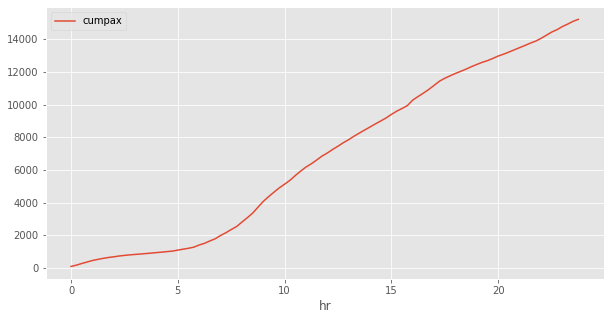

In [21]:
pu_sum[(pu_sum['zone'] == 145) & (pu_sum['day'] == 'weekday')].plot(x='hr',y='cumpax')


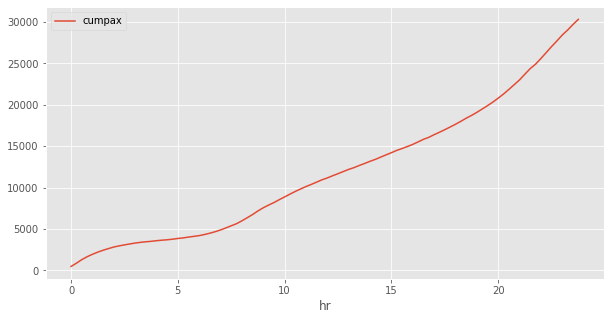

In [22]:
do_sum[(do_sum['zone'] == 145) & (do_sum['day'] == 'weekday')].plot(x='hr',y='cumpax')

In [23]:
def plot_cartogram(day, hr):
    '''
    Plots cartogram according to average flux at hour of given day type
    hr must be a float between 0 and 24 inclusive
    day must be in {'weekday','weekend'}
    '''
    # filter sums
    pu_now = pu_sum[(pu_sum['day'] == day) & (pu_sum['hr'] == hr)]
    do_now = do_sum[(do_sum['day'] == day) & (do_sum['hr'] == hr)]

    zones_now = taxi_zones.merge(pu_now,on='zone',how='left').merge(do_now,on='zone',how='left')
    zones_now.fillna(0,inplace=True)
#     zones_now['flux_ratio'] = (zones_now['pu_max'] + zones_now['cumpax_y'] - zones_now['cumpax_x']) / zones_now['pu_max']
#     zones_now['flux_ratio'] = zones_now['cumpax_y'] / zones_now['cumpax_x']
    zones_now['flux_ratio'] = 1 + (zones_now['cumpax_y'] - zones_now['cumpax_x']) / zones_now['cumpax_x']
    zones_now['flux_ratio'].replace(np.inf,1,inplace=True)
    zones_now['flux_ratio'].replace(np.nan,1,inplace=True)
    zones_now['flux_ratio'].replace(0,.1,inplace=True)

    # set figure
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(10, 10)
    fig.set_dpi(100)
    
    # plot cartogram
    carto = make_cartogram(zones_now, 'flux_ratio', 3, inplace=False);
    carto_plot = carto.plot(column='pax_y',cmap='cividis',ax=ax);
    carto_plot.axis("off");
        
    file_name = os.path.join("anim", day, str(f"hr_{hr}.png"));
    plt.savefig(file_name, bbox_inches="tight", pad_inches=0.1);
    plt.close()
                             
    return file_name

In [24]:
# test the function
plot_cartogram('weekday',1.0)
plot_cartogram('weekday',5.0)
plot_cartogram('weekday',9.0)
plot_cartogram('weekday',13.0)
plot_cartogram('weekday',17.0)
plot_cartogram('weekday',21.0)


'anim/weekday/hr_21.0.png'

In [25]:
# array of times
hrs = (round(x * 0.25,2) for x in range(0, 24*4))

In [26]:
# create cartogram frames
# for day in ['weekday','weekend']:

day = 'weekday'

# create frames
image_files = []
for hr in hrs:
    file_name = plot_cartogram(day,hr)
    image_files.append(file_name)

In [27]:
# create gif
images = []
for file_name in image_files:
    images.append(imageio.imread(file_name))

gif_path = str(f"movie_{day}.gif")
imageio.mimsave(gif_path, images, fps=10)